In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [4]:
r = readers.CollectionReader('../src/clip_experiment/agents')

100%|██████████| 480/480 [01:10<00:00,  6.79it/s]


In [5]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [6]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      #'kl_penalty_coeff': [3, 0.0],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      'clip_advantages': [3, 5, 1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [7]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

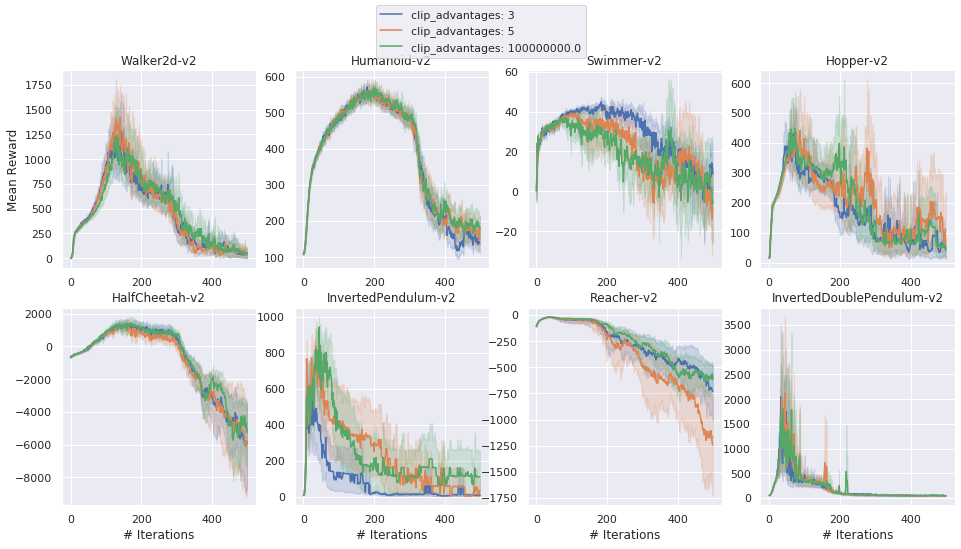

In [19]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

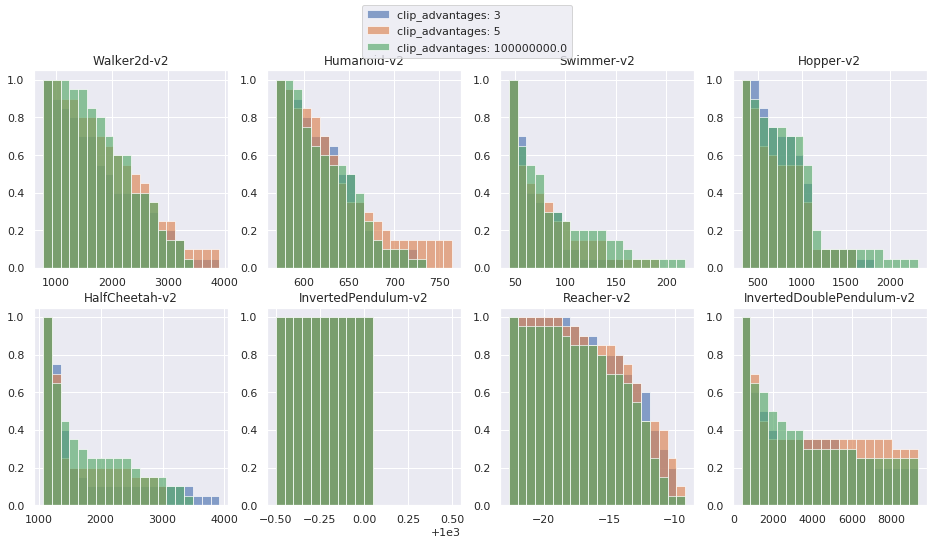

In [10]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

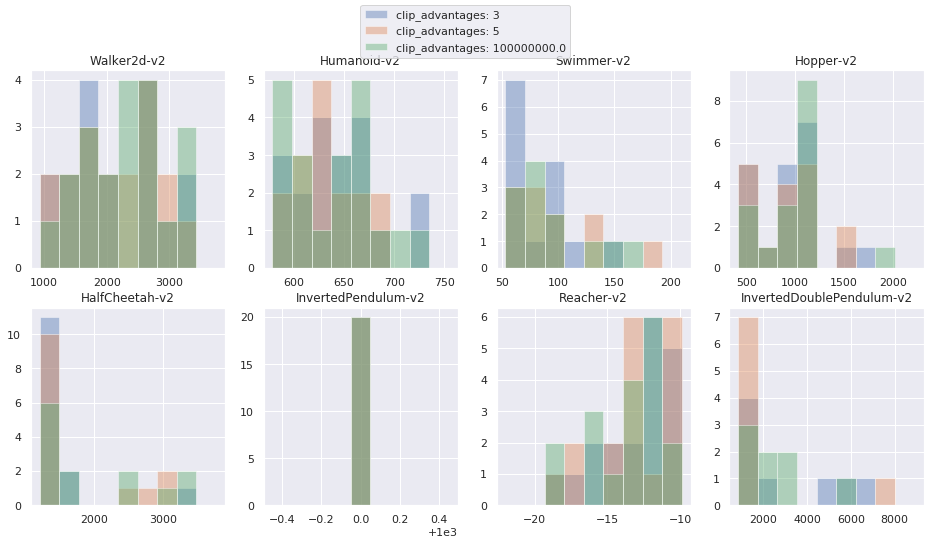

In [11]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), 10)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [12]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [13]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward  \
game                      clip_advantages                           
HalfCheetah-v2            3.0                  0      1550.076376   
                          5.0                  1      1540.283532   
                          100000000.0          2      1700.376780   
Hopper-v2                 3.0                  3       919.706842   
                          5.0                  4       829.178534   
                          100000000.0          5       991.132754   
Humanoid-v2               3.0                  6       640.774608   
                          5.0                  7       648.823277   
                          100000000.0          8       640.025281   
InvertedDoublePendulum-v2 3.0                  9      3371.303994   
                          5.0                 10      3765.390094   
                          100000000.0         11      3610.029709   
Reacher-v2                3.0                 15       -12.834813   
                          5.0                 16       -12.847805   
                          100000000.0         17       -13.949116   
Swimmer-v2                3.0                 18        69.574314   
                          5.0                 19        76.954871   
                          100000000.0         20        84.594481   
Walker2d-v2               3.0                 21      2034.552565   
                          5.0                 22      2300.678510   
                          100000000.0         23      2299.625863   

                                                stddev  max_max_reward  \
game                      clip_advantages                                
HalfCheetah-v2            3.0               738.699442     3916.892370   
                          5.0               681.968677     3916.892370   
                          100000000.0       757.794820     3916.892370   
Hopper-v2                 3.0               336.568959     2320.250348   
                          5.0               386.762767     2320.250348   
                          100000000.0       465.419508     2320.250348   
Humanoid-v2               3.0                42.490850      764.459364   
                          5.0                58.282217      764.459364   
                          100000000.0        41.722456      764.459364   
InvertedDoublePendulum-v2 3.0              3601.263847     9359.568716   
                          5.0              4035.792398     9359.568716   
                          100000000.0      3636.169405     9359.568716   
Reacher-v2                3.0                 2.572605       -9.218304   
                          5.0                 2.778366       -9.218304   
                          100000000.0         3.267282       -9.218304   
Swimmer-v2                3.0                27.786343      218.696338   
                          5.0                37.645890      218.696338   
                          100000000.0        47.503956      218.696338   
Walker2d-v2               3.0               909.261538     3905.954589   
                          5.0               854.868152     3905.954589   
                          100000000.0       640.926604     3905.954589   

                                           min_max_reward  normalized_score  \
game                      clip_advantages                                     
HalfCheetah-v2            3.0                 1068.224475          0.169150   
                          5.0                 1068.224475          0.165712   
                          100000000.0         1068.224475          0.221912   
Hopper-v2                 3.0                  318.234480          0.300433   
                          5.0                  318.234480          0.255215   
                          100000000.0          318.234480          0.336110   
Humanoid-v2               3.0                  568.574526          0.368584   
                          5.0            

In [15]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'clip_advantages', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


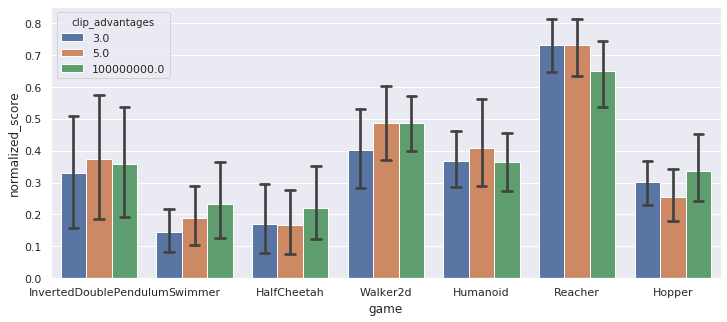

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="clip_advantages",
            data=normalized_score.dropna().reset_index(), capsize=.1)

In [18]:
normalized_score.groupby('clip_advantages').describe()

normalized_score                                               \
                           count      mean       std  min       25%       50%   
clip_advantages                                                                 
3.0                        140.0  0.350006  0.306652  0.0  0.074051  0.271358   
5.0                        140.0  0.373235  0.329736  0.0  0.066462  0.318834   
100000000.0                140.0  0.378438  0.298120  0.0  0.103425  0.342949   

                                
                      75%  max  
clip_advantages                 
3.0              0.598848  1.0  
5.0              0.643455  1.0  
100000000.0      0.620105  1.0